In [ ]:
'''
Dataset link: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

This dataset has 7,043 customers and ~21 attributes with the target column “Churn” indicating whether a customer left within the last month.

'''

In [12]:
"""
Load & Inspect Data
"""
import pandas as pd

df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


(   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  7590-VHVEG  Female              0     Yes         No       1           No   
 1  5575-GNVDE    Male              0      No         No      34          Yes   
 2  3668-QPYBK    Male              0      No         No       2          Yes   
 3  7795-CFOCW    Male              0      No         No      45           No   
 4  9237-HQITU  Female              0      No         No       2          Yes   
 
       MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
 0  No phone service             DSL             No  ...               No   
 1                No             DSL            Yes  ...              Yes   
 2                No             DSL            Yes  ...               No   
 3  No phone service             DSL            Yes  ...              Yes   
 4                No     Fiber optic             No  ...               No   
 
   TechSupport StreamingTV StreamingMovies      

In [2]:
'''
Convert TotalCharges to numeric (it may be stored as object) and handle its missing values:
'''
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].isnull().sum()
df.dropna(subset=["TotalCharges"], inplace=True)


In [ ]:
"""
Encoding Categorical Values:
"""

In [3]:
from sklearn.preprocessing import OneHotEncoder

X = df.drop(columns=["customerID", "Churn"])
y = df["Churn"].map({"Yes":1, "No":0})

cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop='first'), cat_cols),
        ("num", StandardScaler(), num_cols)
    ])


In [4]:
'''
Spliting data into test and train spit dataset samples.
'''
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


In [5]:
"""
Fitting data on Logistic Regression model
"""

from sklearn.linear_model import LogisticRegression

log_reg = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object'))])),
                ('model', LogisticRegression(max_iter=1000))])

In [6]:
"""

Fitting data on SVM model
"""
from sklearn.svm import LinearSVC

svm = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LinearSVC())
])

svm.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object'))])),
                ('model', LinearSVC())])

In [7]:
"""
Hyperparameters to tune:

C: inverse regularization strength
penalty: regularization type (l2, none)
"""
from sklearn.model_selection import GridSearchCV

param_grid_lr = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l2"]
}

grid_lr = GridSearchCV(log_reg, param_grid_lr, scoring="roc_auc", cv=5)
grid_lr.fit(X_train, y_train)

print("Best LR params:", grid_lr.best_params_)


Best LR params: {'model__C': 1, 'model__penalty': 'l2'}


In [13]:
"""
Hyperparameter for SVM:
"""
param_grid_svm = {"model__C": [0.01, 0.1, 1, 10]}
grid_svm = GridSearchCV(svm, param_grid_svm, scoring="roc_auc", cv=5)
grid_svm.fit(X_train, y_train)

print("Best SVM params:", grid_svm.best_params_)


Best SVM params: {'model__C': 1}


In [14]:
"""
Compare roc_auc_lr vs roc_auc_svm.
The model with higher ROC-AUC is chosen as the final model.
"""
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_probs_lr = grid_lr.predict_proba(X_test)[:,1]
roc_auc_lr = roc_auc_score(y_test, y_probs_lr)

y_dec_svm = grid_svm.decision_function(X_test)
roc_auc_svm = roc_auc_score(y_test, y_dec_svm)

print("ROC-AUC LR:", roc_auc_lr)
print("ROC-AUC SVM:", roc_auc_svm)


ROC-AUC LR: 0.8378926545675492
ROC-AUC SVM: 0.835732673255933


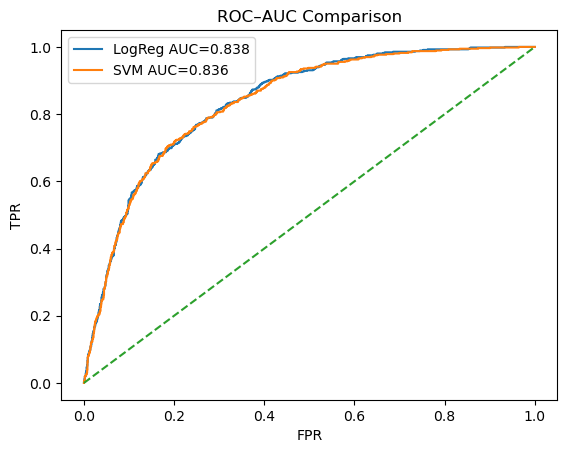

In [10]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probs_lr)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_dec_svm)

plt.plot(fpr_lr, tpr_lr, label=f"LogReg AUC={roc_auc_lr:.3f}")
plt.plot(fpr_svm, tpr_svm, label=f"SVM AUC={roc_auc_svm:.3f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC–AUC Comparison")
plt.legend()
plt.show()


In [ ]:
"""
Threshold Choice was taken as such beacause:

Default threshold = 0.5:
Binary predictions are made by comparing probabilities to 0.5.
Why choose a custom threshold?
ROC only measures ranking quality, not threshold. But business need may penalize churn misclassification asymmetrically (false negatives vs false positives). 
If missing churners is costly, choose a threshold that increases TPR even if FPR increases.

"""